In [57]:
import pickle
import pandas as pd
import re
import string
import nltk
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from collections import Counter
from nltk import word_tokenize, pos_tag
from gensim import matutils, models
from wordcloud import WordCloud
from stop_words import get_stop_words

In [58]:
# Specify which language you're using (ex : 'french', 'english'):
lang = 'french' 

### Load pickled data ###

In [59]:
path_to_extracts = 'volodymyr_graphs/graph_test_deg_1_2_fr_extracts.pkl'

df = pd.read_pickle(path_to_extracts)
df.head()

,Id,Degree,modularity_class,title,extract
650,415357,13,0,Maurice Audin,"Maurice Audin, né le 14 février 1932 à Béja (T..."
745,140607,4,0,Marcel Bigeard,"Marcel Bigeard, né le 14 février 1916 à Toul e..."
410,390950,2,0,Cotignac,Cotignac est une commune française située dans...
25,164090,2,0,Châteaudouble (Var),Châteaudouble est une commune française située...
415,3811608,1,0,Mitidja,"La Mitidja, (en arabe : متيجة, en berbère : Me..."


Group by modularity class :

In [60]:
grouped_extract = df.groupby("modularity_class")['extract'].apply(' '.join).reset_index()

### Clean the data

In [61]:
# Apply a first round of text cleaning techniques

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.strip()
    text = text.lower()
    text = text.replace('\n', ' ')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', u'', text)  #remove non-latin chars 
    return text

round1 = lambda x: clean_text_round1(x)

In [62]:
data_clean = pd.DataFrame(grouped_extract.extract.apply(round1))
data_clean.head()

,extract
0,maurice audin né le février à béja tunisie e...
1,emmanuel yarborough surnommé manny yarborough ...
2,danijel subašić né le octobre à zadar yougos...
3,sahr senesie né le juin à koindu au sierra l...
4,pierre moscovici né le septembre dans le ar...


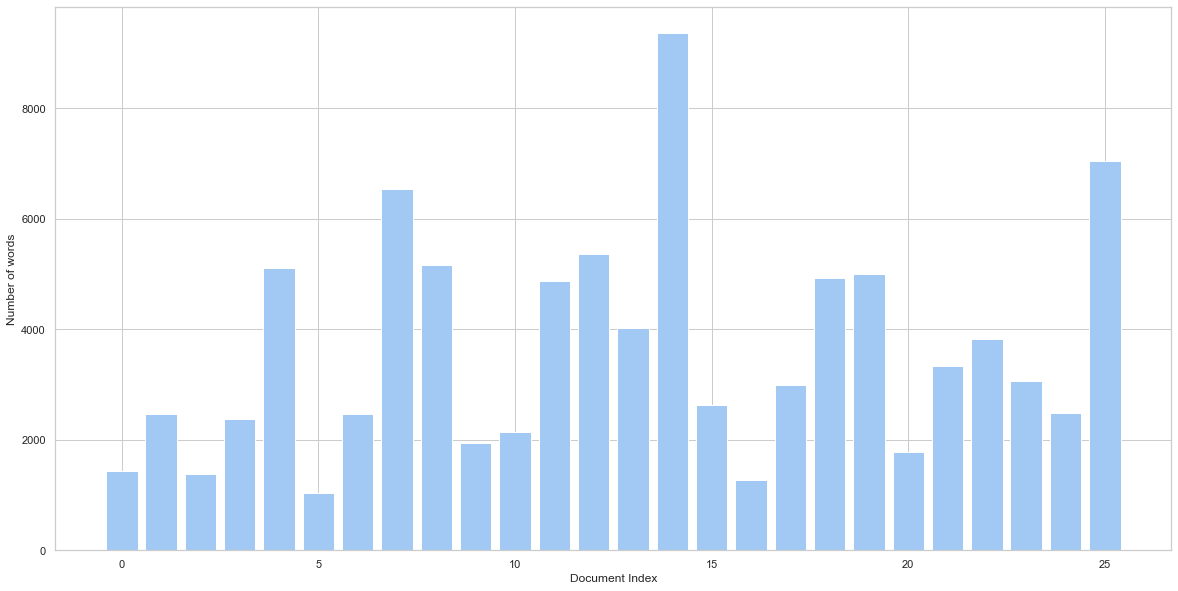

In [63]:
fig, ax = plt.subplots()
ax.bar(data_clean.extract.str.len().sort_index().keys(), data_clean.extract.str.split().str.len())
plt.xlabel('Document Index');
plt.ylabel('Number of words');

### Create Document-Term Matrix

In [64]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

if lang == 'english':
    stop_words = 'english'
elif lang == 'french':
    stop_words = get_stop_words('fr') 

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.extract)

data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm.head()

,aahoo,aaron,abaisse,abandon,abandonnait,abandonnant,abandonne,abandonnent,abandonné,abandonnée,...,œuvre,œuvres,œuvré,šaab,šaabī,šafářová,šarec,škoda,šubertová,żagań
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [65]:
# Find the top 30 words in each cluster

top_dict = {}
for c in data_dtm.transpose().columns:
    top = data_dtm.transpose()[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [66]:
# Look at the most common top words --> add them to the stop word list
# Let's first pull out the top 30 words for each cluster

words = []
for cluster in data_dtm.transpose().columns:
    top = [word for (word, count) in top_dict[cluster]]
    for t in top:
        words.append(t)
        

In [67]:
# # If more than half of the cluster have it as a top word, exclude it from the list

# add_stop_words = [word for word, count in Counter(words).most_common() if count > 10]
add_stop_words = []

In [68]:
# Let's update our document-term matrix with the new list of stop words

# Add new stop words
if lang == 'english':
    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
elif lang == 'french':
    stop_words = get_stop_words('fr') + add_stop_words

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.extract)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index


## Topic Modeling 

### First Attempt : all the words

In [70]:
# One of the required inputs is a term-document matrix
tdm = data_stop.transpose()
tdm.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
aahoo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
aaron,0,0,0,2,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
abaisse,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
abandonnait,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [72]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [96]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes

lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=30)
first_list = lda.print_topics()
first_list

[(0,
  '0.008*"tennis" + 0.008*"titres" + 0.007*"plus" + 0.006*"grand" + 0.006*"double" + 0.006*"chelem" + 0.005*"simple" + 0.005*"remporté" + 0.004*"dont" + 0.004*"masters"'),
 (1,
  '0.008*"septembre" + 0.006*"plus" + 0.003*"né" + 0.003*"world" + 0.003*"center" + 0.003*"trade" + 0.003*"entre" + 0.003*"après" + 0.003*"monde" + 0.003*"dun"'),
 (2,
  '0.009*"né" + 0.007*"plus" + 0.007*"français" + 0.005*"film" + 0.004*"née" + 0.003*"après" + 0.003*"septembre" + 0.003*"française" + 0.003*"grand" + 0.003*"mort"'),
 (3,
  '0.010*"né" + 0.009*"français" + 0.005*"france" + 0.004*"football" + 0.004*"paris" + 0.004*"française" + 0.004*"née" + 0.003*"plus" + 0.003*"footballeur" + 0.003*"acteur"'),
 (4,
  '0.007*"septembre" + 0.007*"français" + 0.006*"rugby" + 0.005*"france" + 0.005*"française" + 0.005*"club" + 0.004*"né" + 0.004*"politique" + 0.004*"plus" + 0.003*"nationale"')]

### Second Attempt : nouns only

In [74]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joellehanna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/joellehanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [75]:
# Let's create a function to pull out nouns from a string of text
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text,language=lang)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [76]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns = pd.DataFrame(data_clean.extract.apply(nouns))
data_nouns.head()

,extract
0,maurice audin le béja tunisie déclaré mort le ...
1,emmanuel surnommé manny le septembre à rahway ...
2,danijel subašić le octobre à zadar yougoslavie...
3,sahr senesie le juin à koindu sierra leone foo...
4,moscovici né le septembre dans arrondissement ...


In [77]:
# Create a new document-term matrix using only nouns :

cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.extract)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn.head()

,aahoo,aaron,abandonnait,abandonné,abandonnée,abattons,abattu,abattus,abbaye,abbayes,...,œuvre,œuvres,œuvré,šaab,šaabī,šafářová,šarec,škoda,šubertová,żagań
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [78]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [79]:
ldan = models.LdaModel(corpus=corpusn, num_topics=5, id2word=id2wordn, passes=30)
second_list = ldan.print_topics()
second_list

[(0,
  '0.008*"formule" + 0.007*"prix" + 0.006*"automobile" + 0.005*"points" + 0.005*"groupe" + 0.005*"pilote" + 0.005*"monde" + 0.005*"championnat" + 0.004*"renault" + 0.004*"team"'),
 (1,
  '0.008*"français" + 0.008*"française" + 0.006*"france" + 0.005*"septembre" + 0.004*"politique" + 0.004*"juin" + 0.004*"mai" + 0.003*"née" + 0.003*"lors" + 0.003*"mort"'),
 (2,
  '0.009*"français" + 0.007*"film" + 0.007*"septembre" + 0.006*"acteur" + 0.004*"mort" + 0.004*"france" + 0.004*"française" + 0.003*"sorti" + 0.003*"paris" + 0.003*"réalisateur"'),
 (3,
  '0.007*"septembre" + 0.006*"world" + 0.006*"center" + 0.006*"trade" + 0.005*"parti" + 0.005*"film" + 0.004*"york" + 0.004*"politique" + 0.004*"français" + 0.003*"france"'),
 (4,
  '0.008*"football" + 0.007*"poste" + 0.007*"france" + 0.006*"footballeur" + 0.006*"club" + 0.006*"tennis" + 0.006*"septembre" + 0.006*"joueur" + 0.005*"monde" + 0.005*"chelem"')]

### Third Attempt : nouns and adjectives only

In [80]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text,language=lang)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [81]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(data_clean.extract.apply(nouns_adj))
data_nouns_adj.head()

,extract
0,maurice audin né le à béja tunisie déclaré mor...
1,emmanuel surnommé manny né le septembre à rahw...
2,danijel subašić né le octobre à zadar yougosla...
3,sahr senesie né le juin à koindu au sierra leo...
4,pierre moscovici né le septembre dans le arron...


In [82]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.extract)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna.head()

,aahoo,aaron,abaisse,abandonnait,abandonnant,abandonnent,abandonné,abandonnée,abattons,abattu,...,œuvre,œuvres,œuvré,šaab,šaabī,šafářová,šarec,škoda,šubertová,żagań
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [83]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [84]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=5, id2word=id2wordna, passes=30)
third_list = ldana.print_topics()
third_list

[(0,
  '0.008*"grand" + 0.006*"football" + 0.006*"international" + 0.006*"footballeur" + 0.006*"poste" + 0.004*"prix" + 0.004*"championnat" + 0.004*"formule" + 0.003*"évolue" + 0.003*"coupe"'),
 (1,
  '0.006*"film" + 0.004*"world" + 0.004*"center" + 0.004*"acteur" + 0.004*"trade" + 0.004*"new" + 0.003*"étatsunis" + 0.003*"américain" + 0.003*"américaine" + 0.003*"groupe"'),
 (2,
  '0.005*"politique" + 0.004*"gouvernement" + 0.003*"grégoire" + 0.003*"ministre" + 0.003*"groupe" + 0.003*"membre" + 0.003*"président" + 0.003*"parti" + 0.003*"tennis" + 0.003*"nationale"'),
 (3,
  '0.006*"film" + 0.004*"parti" + 0.004*"acteur" + 0.004*"dune" + 0.003*"politique" + 0.003*"actrice" + 0.003*"réalisé" + 0.003*"sorti" + 0.002*"grand" + 0.002*"partir"'),
 (4,
  '0.007*"club" + 0.004*"xv" + 0.004*"championnat" + 0.004*"stade" + 0.003*"poste" + 0.003*"trois" + 0.003*"top" + 0.003*"combat" + 0.003*"rugby" + 0.003*"sport"')]

## Display best result 

In [97]:
sns.set(style="whitegrid")
sns.set_palette("pastel")

def show_lda_bars(list_topics):
    for i in range(0, len(list_topics)):
        x = []
        y = []
        df = pd.DataFrame()
        plt.figure()
        
        topics = list_topics[i][1].split('+')
        for j in range(0, len(topics)):
            y.append(topics[j].split('*')[0])
            x.append(topics[j].split('*')[1].replace('"',''))
        df["x"] = x
        df["y"] = y
        df["y"] = df["y"].astype(float)
        plt.xticks(rotation=45)
        sns.barplot(x="x", y="y", data=df)
        plt.ylabel('')
        plt.xlabel('')
        plt.title(f'Words of topic {i+1}')
    return df


def show_word_clouds(list_topics):
    plt.rcParams['figure.figsize'] = [20, 10]
    for i in range(0, len(list_topics)):
        plt.subplot(1, 5, i+1)
        wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
        x = []
        y = []
        df = pd.DataFrame()
        
        topics = list_topics[i][1].split('+')
        for j in range(0, len(topics)):
            y.append(topics[j].split('*')[0])
            x.append(topics[j].split('*')[1].replace('"',''))
        df["x"] = x
        df["y"] = y
        df["y"] = df["y"].astype(float)
        
        words = []
        for row in df.iterrows():
            row[1]["x"] = (((row[1]["x"]+' ')*int(row[1]["y"]*1000)).strip())
            words.append(row[1]["x"])
        
        wc.generate(' '.join(words))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")

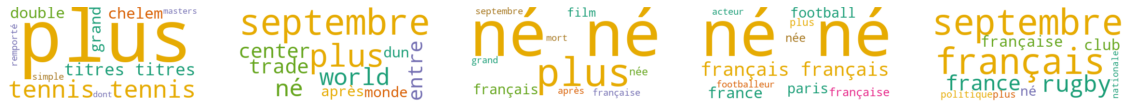

In [98]:
show_word_clouds(first_list)

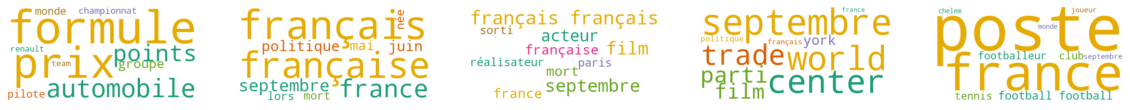

In [87]:
show_word_clouds(second_list)

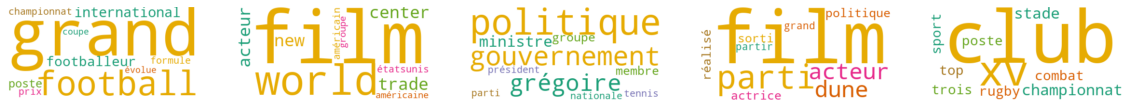

In [88]:
show_word_clouds(third_list)

## Identify topics in each class

In [67]:
# Let's take a look at which topics each transcript contains
corpus_transformed = ldana[corpusna]
#list(zip([a for [(a,b)] in corpus_transformed], data_dtm.index))
try:
    listt = list(zip(corpus_transformed, data_dtm.index))
except IndexError:
    pass

In [68]:
for i in range(0, len(listt)):
    list_of_topics = []
    for j in range(0, len(listt[i][0])):
        list_of_topics.append(listt[i][0][j][0])
    print('Class:' , listt[i][1], 'Topic(s):', list_of_topics)

Class: 0 Topic(s): [2, 4]
Class: 1 Topic(s): [2]
Class: 2 Topic(s): [0, 1]
Class: 3 Topic(s): [4]
Class: 4 Topic(s): [0]
Class: 5 Topic(s): [2]
Class: 6 Topic(s): [0]
Class: 7 Topic(s): [4]
Class: 8 Topic(s): [0, 4]
Class: 9 Topic(s): [0, 2]
Class: 10 Topic(s): [2]
Class: 11 Topic(s): [4]
Class: 12 Topic(s): [1]
Class: 13 Topic(s): [1, 3, 4]
Class: 14 Topic(s): [1, 3, 4]
Class: 15 Topic(s): [1, 3]
Class: 16 Topic(s): [2]
Class: 17 Topic(s): [1]
Class: 18 Topic(s): [1, 2, 4]
Class: 19 Topic(s): [2]
Class: 20 Topic(s): [2, 3]
Class: 21 Topic(s): [0]
Class: 22 Topic(s): [0, 4]
Class: 23 Topic(s): [2]
Class: 24 Topic(s): [4]
Class: 25 Topic(s): [0, 1]
Class: 26 Topic(s): [2]
Class: 27 Topic(s): [2]
Class: 28 Topic(s): [1, 2]
Class: 29 Topic(s): [0, 1, 3]
Class: 30 Topic(s): [1, 3, 4]
Class: 31 Topic(s): [0, 1, 4]
Class: 32 Topic(s): [2]
Class: 33 Topic(s): [0, 2, 3]
Class: 34 Topic(s): [2]
Class: 35 Topic(s): [4]
Class: 36 Topic(s): [0, 4]
Class: 37 Topic(s): [0]
Class: 38 Topic(s): [1]
Cl